---
title: "overfitting and underfitting"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---

In [1]:
#| code-summary: "import libraries"
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", font_scale=1.2)
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from numpy.polynomial import Chebyshev

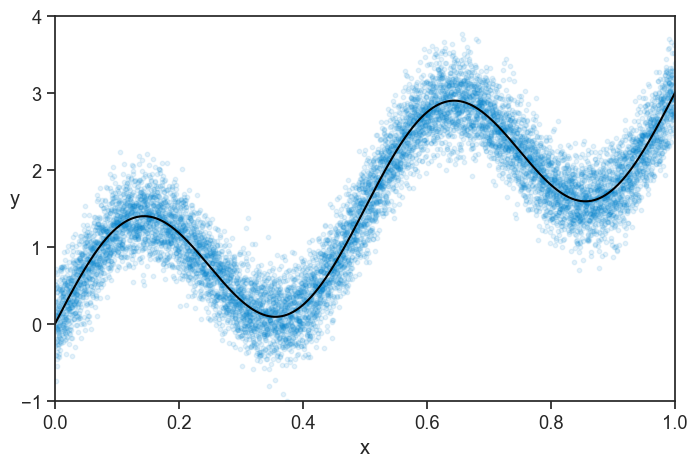

In [19]:
#| code-summary: "plot"
np.random.seed(0)
N = 10000
f = lambda x: np.sin(4*np.pi*x) + 3*x
blue = "xkcd:cerulean"
gold = "xkcd:gold"
pink = "xkcd:hot pink"
green = "xkcd:forest"

x_pop = np.linspace(0, 1, N)
noise_pop = np.random.normal(0, 0.3, size=N)
y_pop = f(x_pop) + noise_pop
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x_pop, f(x_pop), color='black', label=r'true function, $f(x)$')
ax.scatter(x_pop, y_pop, s=10, alpha=0.1, color=blue, label=r'noisy data, $y = f(x) + \epsilon$')
ax.set(xlabel="x",
        xlim=(x_pop[0], x_pop[-1]),
        ylim=(-1, 4))
ax.set_ylabel("y", rotation=0);
# ax.legend(loc='upper left', frameon=False)

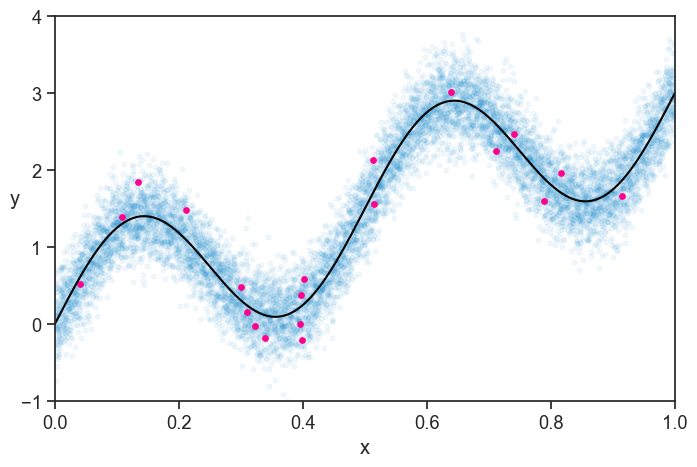

In [47]:
#| code-summary: "plot"
np.random.seed(628)
n = 20
idx = np.random.choice(N, size=n, replace=False)
data_x = x_pop[idx]
data_y = y_pop[idx]

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x_pop, f(x_pop), color='black', label=r'true function, $f(x)$')
ax.scatter(x_pop, y_pop, s=10, alpha=0.05, color=blue, label=r'noisy data, $y = f(x) + \epsilon$')
ax.scatter(data_x, data_y, s=15, alpha=1, color=pink, label=r'noisy data, $y = f(x) + \epsilon$')
ax.set(xlabel="x",
        xlim=(x_pop[0], x_pop[-1]),
        ylim=(-1, 4))
ax.set_ylabel("y", rotation=0);
# ax.legend(loc='upper left', frameon=False)

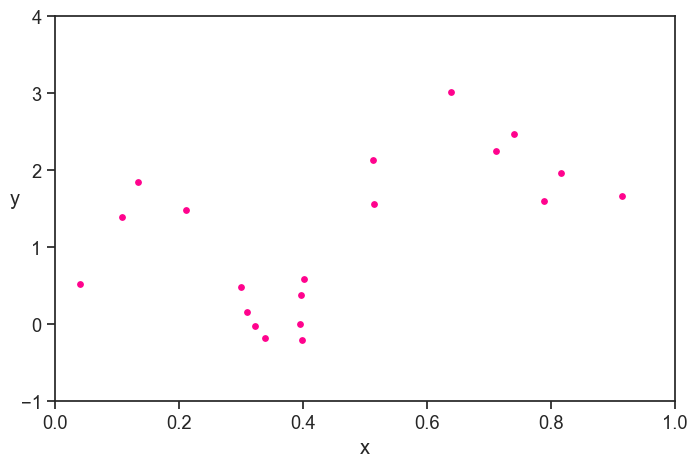

In [48]:
#| code-summary: "plot"
fig, ax = plt.subplots(figsize=(8, 5))
noise = np.random.normal(0, 0.3, size=N)
# ax.plot(x_grid, f(x_grid), color='black', label=r'true function, $f(x)$')
ax.scatter(data_x, data_y, s=15, alpha=1, color=pink, label=r'noisy data, $y = f(x) + \epsilon$', clip_on=False)
ax.set(xlabel="x",
        xlim=(x_grid[0], x_grid[-1]),
        ylim=(-1, 4))
ax.set_ylabel("y", rotation=0);
# ax.legend(loc='upper left', frameon=False)

We do not split data because we like throwing data away.
We split data because evaluating a model on the data it was trained on answers the wrong question.

<!-- Core question

Where does prediction error come from?

Main goal

Make bias and variance visible, not operational.

Topics to cover

synthetic data from a known function

repeated datasets (or resampling)

polynomial fits of varying degree

averaging predictions at fixed x

visualization of:

mean prediction (bias)

spread of predictions (variance)

conceptual error decomposition (no heavy math) -->